 # A 2-step CNN

Conclusions: il n'y a pas de différence notables entre sur le data test à la fin de ce notebook

je teste ici des modèles de CNN
globalement il faut beacoup de données

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
from sklearn.model_selection import train_test_split
import joblib

## DATASETS

## STEP 1: Classification Normal/Abnormal

In [2]:
#dataset 2 classe 1
X2_1,y2_1 = load_balanced.load('../data/raw/ptbdb_abnormal.csv')
#dataset 2 classe 0
X2_0,y2_0 = load_balanced.load('../data/raw/ptbdb_normal.csv')
#dataset 1 multi classes
X1,y1 = load_balanced.load('../data/raw/mitbih_train.csv')

In [3]:
# transforme tout ce qui n'est pas classe 0 en classe 1
y1[y1>0]=1
# concat base 2
X2 = np.concatenate((X2_1,X2_0))
y2 = np.concatenate((y2_1,y2_0))
# compate

In [4]:
print(pd.Series(y2).value_counts())
print(pd.Series(y1).value_counts())

1.0    10506
0.0     4046
Name: count, dtype: int64
0.0    72471
1.0    15083
Name: count, dtype: int64


 au total j'ai 10506+15083 = 25589 signaux de classe 1.
 
 il m'en faut autant de la classe 0.
 
 j'en ai 4046 dans le dataset 2, il faut que j'en prenne 21553 du dataset 1

In [5]:
n_classe0_in_dataset1 = 21553

In [6]:
# ok don on va undersampler la classe 0 du dataset 1
print(X1.shape)
ii = np.arange(X1.shape[0])
np.random.shuffle(ii)
# deja on shuffle si jamais les classes sont dans un ordre particulier
Xs = X1[ii,:]
ys = y1[ii]
print(Xs.shape)

(87554, 187)
(87554, 187)


In [7]:
c0 = [k for k,x in enumerate(ys) if x==0] # indices des sgnaux de classe 0
c1 = [k for k,x in enumerate(ys) if x==1] # indices des sgnaux de classe 1
# et je vais prendre n_classe0_in_dataset1 signaux de la classe 0 et tous les signaux de la classe 1
c0 = c0[0:n_classe0_in_dataset1]

X1p = np.concatenate((Xs[c0,:],Xs[c1,:]))
y1p=  np.concatenate((ys[c0],ys[c1]))

# et puis on reshuffle le tout car la c'est dans l'ordre 0/1
ii = np.arange(X1p.shape[0])
np.random.shuffle(ii)
X1p = X1p[ii,:]
y1p = y1p[ii]

In [8]:
X = np.concatenate((X1p,X2))
y = np.concatenate((y1p,y2))
print(pd.Series(y).value_counts())

0.0    25599
1.0    25589
Name: count, dtype: int64


In [9]:
X_train,X_cross, y_train, y_cross = train_test_split(X,y,test_size=0.1,random_state=12)

A ce stade j'un un dataset conséquent qui n'a pas d'oversample. on peut déjà essayer ca

### conversion en pytorch dataset

In [10]:
X_train = np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)

In [11]:


train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

In [12]:
X_train.shape

(46069, 1, 187)

## MODEL

In [13]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):

    best_accuracy = 0
    optimizer = optim.Adam(model.parameters(), lr)

    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

In [14]:
def cnn_type_1(n,n_neural, activation=nn.ReLU,input_shape=187,device='cpu',dropout=0.2):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n, kernel_size=11, stride=1, padding=0), # shape: (batch_size, n, 181)
        activation(),
        nn.BatchNorm1d(num_features=n),
        nn.MaxPool1d(5, stride=5), # shape: (batch_size, n, 90)
        
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 86)
        activation(),
        nn.BatchNorm1d(num_features=n),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 43)
        
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 41)
        activation(),
        nn.BatchNorm1d(num_features=n),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 20)
        
        nn.Flatten() , # shape: (batch_size, 9*n)
        nn.Dropout(dropout),
        nn.Linear(6*n, n_neural),
        activation(),
        nn.Linear(n_neural, 2),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            960
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            44,880
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           24,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           102
Total params: 89,752
Trainable params: 89,752
Non-trainable params: 0
save model
Epoch : 1/25 -- Training loss 0.2639354150621079, --- Val loss 0.189340278506279, --- accuray : 0.9249925

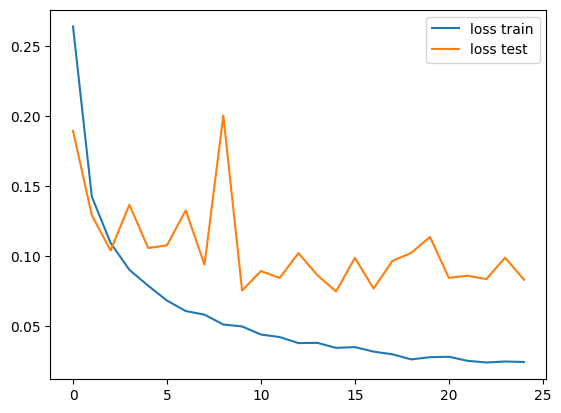

In [15]:
model = cnn_type_1(80,50)
train_a_model(model,train_loader,test_set,epochs =25,lr=1e-3,outmodelname='../models/cnn_ptbdb.pkl')


In [16]:
torch.save(model.state_dict(), '../models/CNN_binary_2datasets_20241022.pt')

## performance sur la base complete

In [17]:
model = cnn_type_1(80,50)
model.load_state_dict(torch.load('../models/CNN_binary_2datasets_20241022.pt', weights_only=True))
model.eval()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            960
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            44,880
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           24,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           102
Total params: 89,752
Trainable params: 89,752
Non-trainable params: 0


Sequential(
  (0): Conv1d(1, 80, kernel_size=(11,), stride=(1,))
  (1): ReLU()
  (2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(80, 80, kernel_size=(7,), stride=(1,))
  (5): ReLU()
  (6): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (9): ReLU()
  (10): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.2, inplace=False)
  (14): Linear(in_features=480, out_features=50, bias=True)
  (15): ReLU()
  (16): Linear(in_features=50, out_features=2, bias=True)
)

In [18]:
X2_1,y2_1 = load_balanced.load('../data/raw/ptbdb_abnormal.csv')
#dataset 2 classe 0
X2_0,y2_0 = load_balanced.load('../data/raw/ptbdb_normal.csv')
X2 = np.concatenate((X2_1,X2_0))
y2 = np.concatenate((y2_1,y2_0))
X2 = np.expand_dims(X2,axis=1)
y_true = y2

In [19]:
model.eval()

with torch.no_grad():
    # Prédiction du modèle pour un batch donné
    y_pred = model(torch.from_numpy(X2).float())
y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
y_pred[y_pred>0] = 1
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted     0      1
True                  
0.0        4013     33
1.0          30  10476
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4046
         1.0       1.00      1.00      1.00     10506

    accuracy                           1.00     14552
   macro avg       0.99      0.99      0.99     14552
weighted avg       1.00      1.00      1.00     14552



## change the model

In [20]:
model=joblib.load('../models/cnn_ptbdb.pkl')
model.eval()

Sequential(
  (0): Conv1d(1, 80, kernel_size=(11,), stride=(1,))
  (1): ReLU()
  (2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(80, 80, kernel_size=(7,), stride=(1,))
  (5): ReLU()
  (6): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv1d(80, 80, kernel_size=(3,), stride=(1,))
  (9): ReLU()
  (10): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.2, inplace=False)
  (14): Linear(in_features=480, out_features=50, bias=True)
  (15): ReLU()
  (16): Linear(in_features=50, out_features=2, bias=True)
)

In [21]:
model[16] = nn.Linear(in_features=50,out_features=5)


##  STEP 2 Retrain

In [22]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=0.05,random_state=12)

X_train =np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

(237500, 1, 187)


### 1 epoch

save model
Epoch : 1/1 -- Training loss 0.2933754746521774, --- Val loss 0.10438338667154312, --- accuray : 0.9675589452211142, --- recall : 0.9675654583043697
execution time:  57.68812656402588
Predicted     0     1     2     3     4
True                                   
0          2380    56     7    27     6
1            62  2367    31    23     2
2            10    14  2426    51    15
3            10     7    47  2383     1
4             3     9    20     3  2540
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2476
           1       0.96      0.95      0.96      2485
           2       0.96      0.96      0.96      2516
           3       0.96      0.97      0.97      2448
           4       0.99      0.99      0.99      2575

    accuracy                           0.97     12500
   macro avg       0.97      0.97      0.97     12500
weighted avg       0.97      0.97      0.97     12500



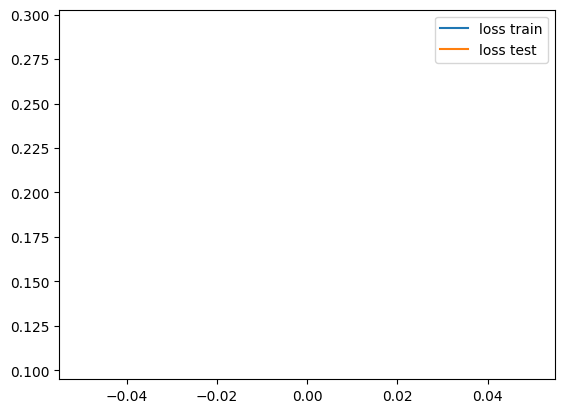

In [23]:
train_a_model(model,train_loader,test_set,epochs = 1,lr=1e-4,outmodelname='../models/cnn_initiated_ptbdb_1epoch.pkl')

#### eval sur test

In [24]:
X_valid, y_valid = load_balanced.load('../data/raw/mitbih_test.csv')
X_valid =np.expand_dims(X_valid,axis=1)

valid_set =  TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))

In [25]:

y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17440  379    82  188    29
1             65  472    12    7     0
2             26   21  1355   38     8
3              6    2     9  145     0
4             11   11    15    4  1567
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.53      0.85      0.66       556
           2       0.92      0.94      0.93      1448
           3       0.38      0.90      0.53       162
           4       0.98      0.97      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.76      0.92      0.81     21892
weighted avg       0.97      0.96      0.96     21892



### 2 epochs

save model
Epoch : 1/1 -- Training loss 0.08874735430353566, --- Val loss 0.056726548820734024, --- accuray : 0.9830331475874143, --- recall : 0.9830814936723453
execution time:  60.06142735481262
Predicted     0     1     2     3     4
True                                   
0          2400    43     9    20     4
1            35  2430     9    11     0
2             5    11  2466    30     4
3             4     0     7  2436     1
4             3     5     8     2  2557
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2476
           1       0.98      0.98      0.98      2485
           2       0.99      0.98      0.98      2516
           3       0.97      1.00      0.98      2448
           4       1.00      0.99      0.99      2575

    accuracy                           0.98     12500
   macro avg       0.98      0.98      0.98     12500
weighted avg       0.98      0.98      0.98     12500



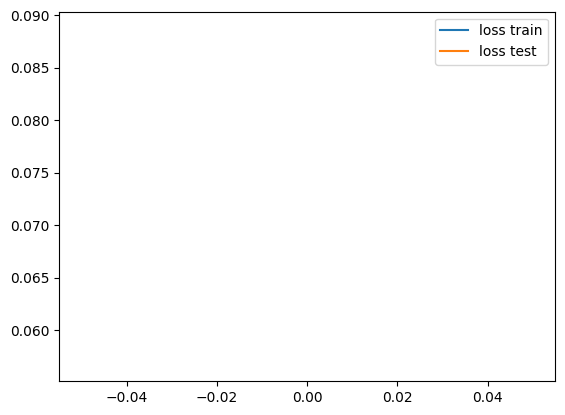

In [26]:
train_a_model(model,train_loader,test_set,epochs = 1,lr=1e-4,outmodelname='../models/cnn_initiated_ptbdb_2epochs.pkl')

#### eval sur test

In [27]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17618  278    82  114    26
1             63  476    14    3     0
2             19   12  1374   34     9
3              5    1    10  146     0
4             11    3    13    1  1580
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.62      0.86      0.72       556
           2       0.92      0.95      0.93      1448
           3       0.49      0.90      0.63       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.80      0.93      0.85     21892
weighted avg       0.98      0.97      0.97     21892



### 7 epochs

save model
Epoch : 1/5 -- Training loss 0.055985764622492225, --- Val loss 0.039662692695856094, --- accuray : 0.9890524919630739, --- recall : 0.9890920359126975
save model
Epoch : 2/5 -- Training loss 0.042332108173617405, --- Val loss 0.03213873878121376, --- accuray : 0.9910025548381103, --- recall : 0.9910230438031611
save model
Epoch : 3/5 -- Training loss 0.03311669957926987, --- Val loss 0.027262020856142044, --- accuray : 0.9923665830106974, --- recall : 0.9923855759467731
save model
Epoch : 4/5 -- Training loss 0.027738704154316923, --- Val loss 0.024044722318649292, --- accuray : 0.9931765087312645, --- recall : 0.9931887770624547
save model
Epoch : 5/5 -- Training loss 0.02342289064954476, --- Val loss 0.022459277883172035, --- accuray : 0.9939741672068241, --- recall : 0.9939845985754259
execution time:  304.78851199150085
Predicted     0     1     2     3     4
True                                   
0          2429    25     9    10     3
1             6  2479     0     

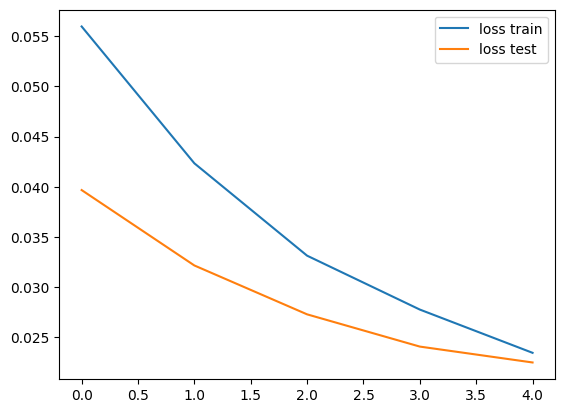

In [28]:
train_a_model(model,train_loader,test_set,epochs = 5,lr=1e-4,outmodelname='../models/cnn_initiated_ptbdb_7epochs.pkl')

#### eval sur test

In [29]:
model=joblib.load('../models/cnn_initiated_ptbdb_7epochs.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17819  177    53   48    21
1             58  484    11    2     1
2             27    6  1380   25    10
3              9    1    12  140     0
4             10    2     8    1  1587
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.72      0.87      0.79       556
           2       0.94      0.95      0.95      1448
           3       0.65      0.86      0.74       162
           4       0.98      0.99      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.86      0.93      0.89     21892
weighted avg       0.98      0.98      0.98     21892



### N epochs

save model
Epoch : 1/20 -- Training loss 0.020303125552906604, --- Val loss 0.020222267135977745, --- accuray : 0.994698450164566, --- recall : 0.9947019684028726
save model
Epoch : 2/20 -- Training loss 0.018057670117123052, --- Val loss 0.01945933885872364, --- accuray : 0.9950295811899503, --- recall : 0.9950155849851156
save model
Epoch : 3/20 -- Training loss 0.01619519858246081, --- Val loss 0.01676103100180626, --- accuray : 0.9960734046778545, --- recall : 0.9960652839966132
save model
Epoch : 4/20 -- Training loss 0.014616765537813894, --- Val loss 0.01609797589480877, --- accuray : 0.9963886791281216, --- recall : 0.9963883857736728
Epoch : 5/20 -- Training loss 0.013293405764368608, --- Val loss 0.01690574921667576, --- accuray : 0.9958475529773445, --- recall : 0.9958116098279012
save model
Epoch : 6/20 -- Training loss 0.011744553846417387, --- Val loss 0.014349346980452538, --- accuray : 0.9967056520853269, --- recall : 0.9967045773734862
Epoch : 7/20 -- Training loss 0.0

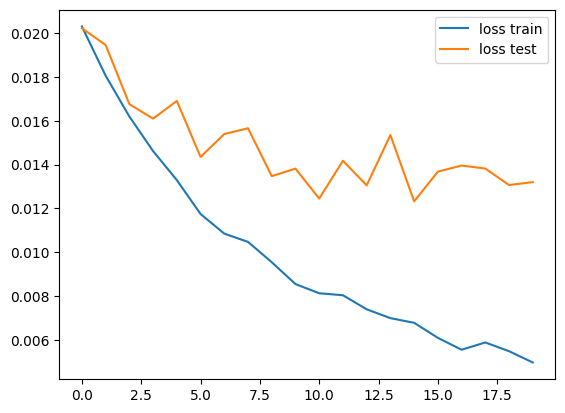

In [30]:
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-4,outmodelname='../models/cnn_initiated_ptbdb_Nepochs.pkl')

#### eval sur test

In [31]:
model=joblib.load('../models/cnn_initiated_ptbdb_Nepochs.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted      0    1     2    3     4
True                                  
0          17957   84    30   33    14
1             78  469     5    3     1
2             29    5  1388   20     6
3             10    1    14  137     0
4             12    0     6    1  1589
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.84      0.84      0.84       556
           2       0.96      0.96      0.96      1448
           3       0.71      0.85      0.77       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.93      0.91     21892
weighted avg       0.98      0.98      0.98     21892



#### reval sur base ptbdb

In [32]:
X2_1,y2_1 = load_balanced.load('../data/raw/ptbdb_abnormal.csv')
#dataset 2 classe 0
X2_0,y2_0 = load_balanced.load('../data/raw/ptbdb_normal.csv')
X2 = np.concatenate((X2_1,X2_0))
y2 = np.concatenate((y2_1,y2_0))
X2 =np.expand_dims(X2,axis=1)
y_true = y2

In [33]:
model.eval()

with torch.no_grad():
    # Prédiction du modèle pour un batch donné
    y_pred = model(torch.from_numpy(X2).float())
y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
y_pred[y_pred>0] = 1
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
print(table)

print(classification_report(y_true, y_pred))

Predicted     0     1
True                 
0.0        3931   115
1.0        6613  3893
              precision    recall  f1-score   support

         0.0       0.37      0.97      0.54      4046
         1.0       0.97      0.37      0.54     10506

    accuracy                           0.54     14552
   macro avg       0.67      0.67      0.54     14552
weighted avg       0.80      0.54      0.54     14552

